In [37]:
import os
import pickle
import warnings

import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from omegaconf import OmegaConf

from retailsynth import REPO_ROOT_DIR
from retailsynth.base_config import load_config_store
from retailsynth.synthesizer.synthesizer_pipeline import run_synthesizer_for_model_estimation
from retailsynth.model.model import SimpleModel

warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# output_path = REPO_ROOT_DIR / "analysis_workflow/4_model_fitting"
# os.chdir(output_path)
# os.getcwd()

# with initialize(version_base=None, config_path="cfg"):
#     load_config_store()
#     cfg = compose(config_name="synthetic_dataset")
#     results = run_synthesizer_for_model_estimation(cfg['synthetic_data'])

Synthesizing trajectory: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


In [ ]:
x, price, trajectory = results
x.shape

(100, 1000, 20)

In [39]:
from numpyro.infer import Predictive, NUTS, MCMC
import numpy as np
import jax


n_steps = 100
n_customers, n_products = 10, 10

X = jnp.array(np.random.rand(n_steps, n_customers, n_products))
P = jnp.array(np.random.rand(n_steps, n_customers, n_products))
C = jnp.array(np.random.randint(0, 2, (n_steps, n_customers)))

# Generate data from the model
model = SimpleModel(n_customers, n_products).product_choice_model
predictive = Predictive(model, num_samples=1)
rng_key = jax.random.PRNGKey(0)
samples = predictive(jax.random.PRNGKey(0), X=X, P=P, C=C)


# Fit the model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(jax.random.PRNGKey(2), X=X, P=P, C=C, B_obs=samples['B'][0])
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [01:12<00:00, 20.59it/s, 255 steps of size 2.27e-02. acc. prob=0.97]



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
                  Z[0]      2.06      0.57      1.99      1.17      2.94    538.11      1.00
                  Z[1]      2.02      0.59      1.96      1.09      2.91    514.64      1.00
                  Z[2]      2.00      0.62      1.95      1.02      2.93    559.74      1.00
                  Z[3]      2.19      0.68      2.07      1.24      3.14    488.12      1.00
                  Z[4]      1.57      0.70      1.62      0.09      2.46    146.27      1.00
                  Z[5]      2.34      0.68      2.23      1.30      3.33    353.47      1.00
                  Z[6]      1.94      0.59      1.88      0.99      2.77    599.58      1.00
                  Z[7]      1.83      0.58      1.82      0.88      2.80    464.60      1.00
                  Z[8]      1.77      0.62      1.76      0.64      2.62    358.59      1.00
                  Z[9]      2.14      0.57      2.06      1.23      2

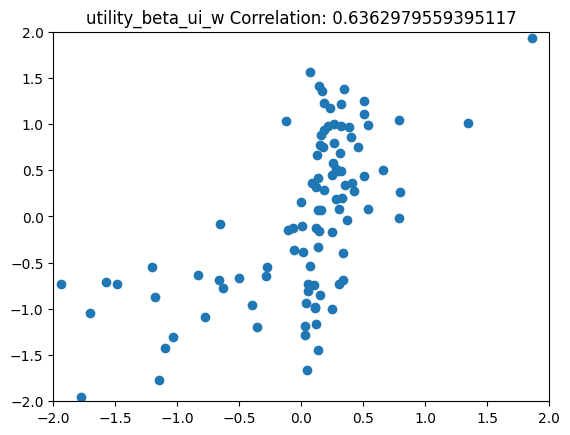

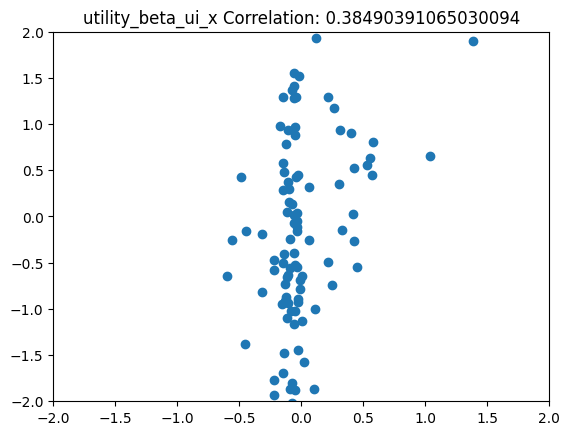

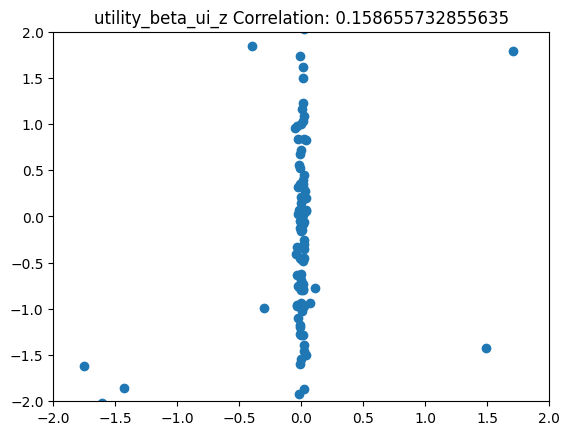

In [73]:
for param_name in mcmc.get_samples().keys():
    if "utility" in param_name:
        plt.figure()
        estimated_params = mcmc.get_samples()[param_name].mean(axis=0).flatten()
        actual_params = samples[param_name][0].flatten()
        correlation = np.corrcoef(estimated_params, actual_params)
        plt.title(param_name + " Correlation: " + str(correlation[0, 1]))

        plt.scatter(estimated_params, actual_params)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)